# Topic Modelling Visualization

Explore multiple strategies to effectively visualize the results using matplotlib plots.

Based on [Gensim Topic Modeling Visualization](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

In [48]:
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

print('Python Version: %s' % (sys.version))

Python Version: 2.7.15 | packaged by conda-forge | (default, Feb 28 2019, 04:00:11) 
[GCC 7.3.0]


In [3]:
dictionary = corpora.Dictionary.load('documents.dict')
corpus = corpora.MmCorpus('documents.mm')
lda_model = models.LdaModel.load('lda_model')
ldamallet = models.wrappers.LdaMallet.load('ldamallet')
optimal_model = models.wrappers.LdaMallet.load('optimal_model')

print(dictionary)
print(corpus)
print(lda_model)
print(ldamallet)

Dictionary(7714 unique tokens: [u'francesco', u'csuci', u'univesidad', u'sation', u'efimenko']...)
MmCorpus(4 documents, 7714 features, 10760 non-zero entries)
LdaModel(num_terms=7714, num_topics=20, decay=0.5, chunksize=100)


/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
import pickle
#with open('documents', 'wb') as f: #save
#    pickle.dump(mylist, f)

with open('documents', 'rb') as f: #load
    documents = pickle.load(f)

## What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic

In [5]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,1.0000,"institut, teach, learn, educ, univers, higher,...","[trend, learn, teach, european, higher, educ, ..."
1,1,17.0,0.8052,"learn, educ, student, univers, http, technolog...","[horizon, report, higher, educ, edit, interest..."
2,2,6.0,1.0000,"innov, educ, chang, oecd, figur, level, grade,...","[educ, research, innov, measur, innov, educ, n..."
3,3,19.0,1.0000,"para, que, aprendizagem, uma, com, nmc, ncia, ...","[panorama, tecnol, gico, nmc, universidad, bra..."


## The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [9]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2.0,1.0000,"institut, teach, learn, educ, univers, higher, student, european, trend, develop","[trend, learn, teach, european, higher, educ, area, michael, gaebel, zhang, author, luisa, bunes..."
1,6.0,1.0000,"innov, educ, chang, oecd, figur, level, grade, point, student, countri","[educ, research, innov, measur, innov, educ, new, perspect, educ, research, innov, measur, innov..."
2,17.0,0.8052,"learn, educ, student, univers, http, technolog, higher, www, institut, nmc","[horizon, report, higher, educ, edit, interest, emerg, technolog, topic, learn, edtech, insight,..."
3,19.0,1.0000,"para, que, aprendizagem, uma, com, nmc, ncia, tecnologia, universidad, como","[panorama, tecnol, gico, nmc, universidad, brasileira, uma, lise, region, horizon, project, resu..."


## Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

In [14]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


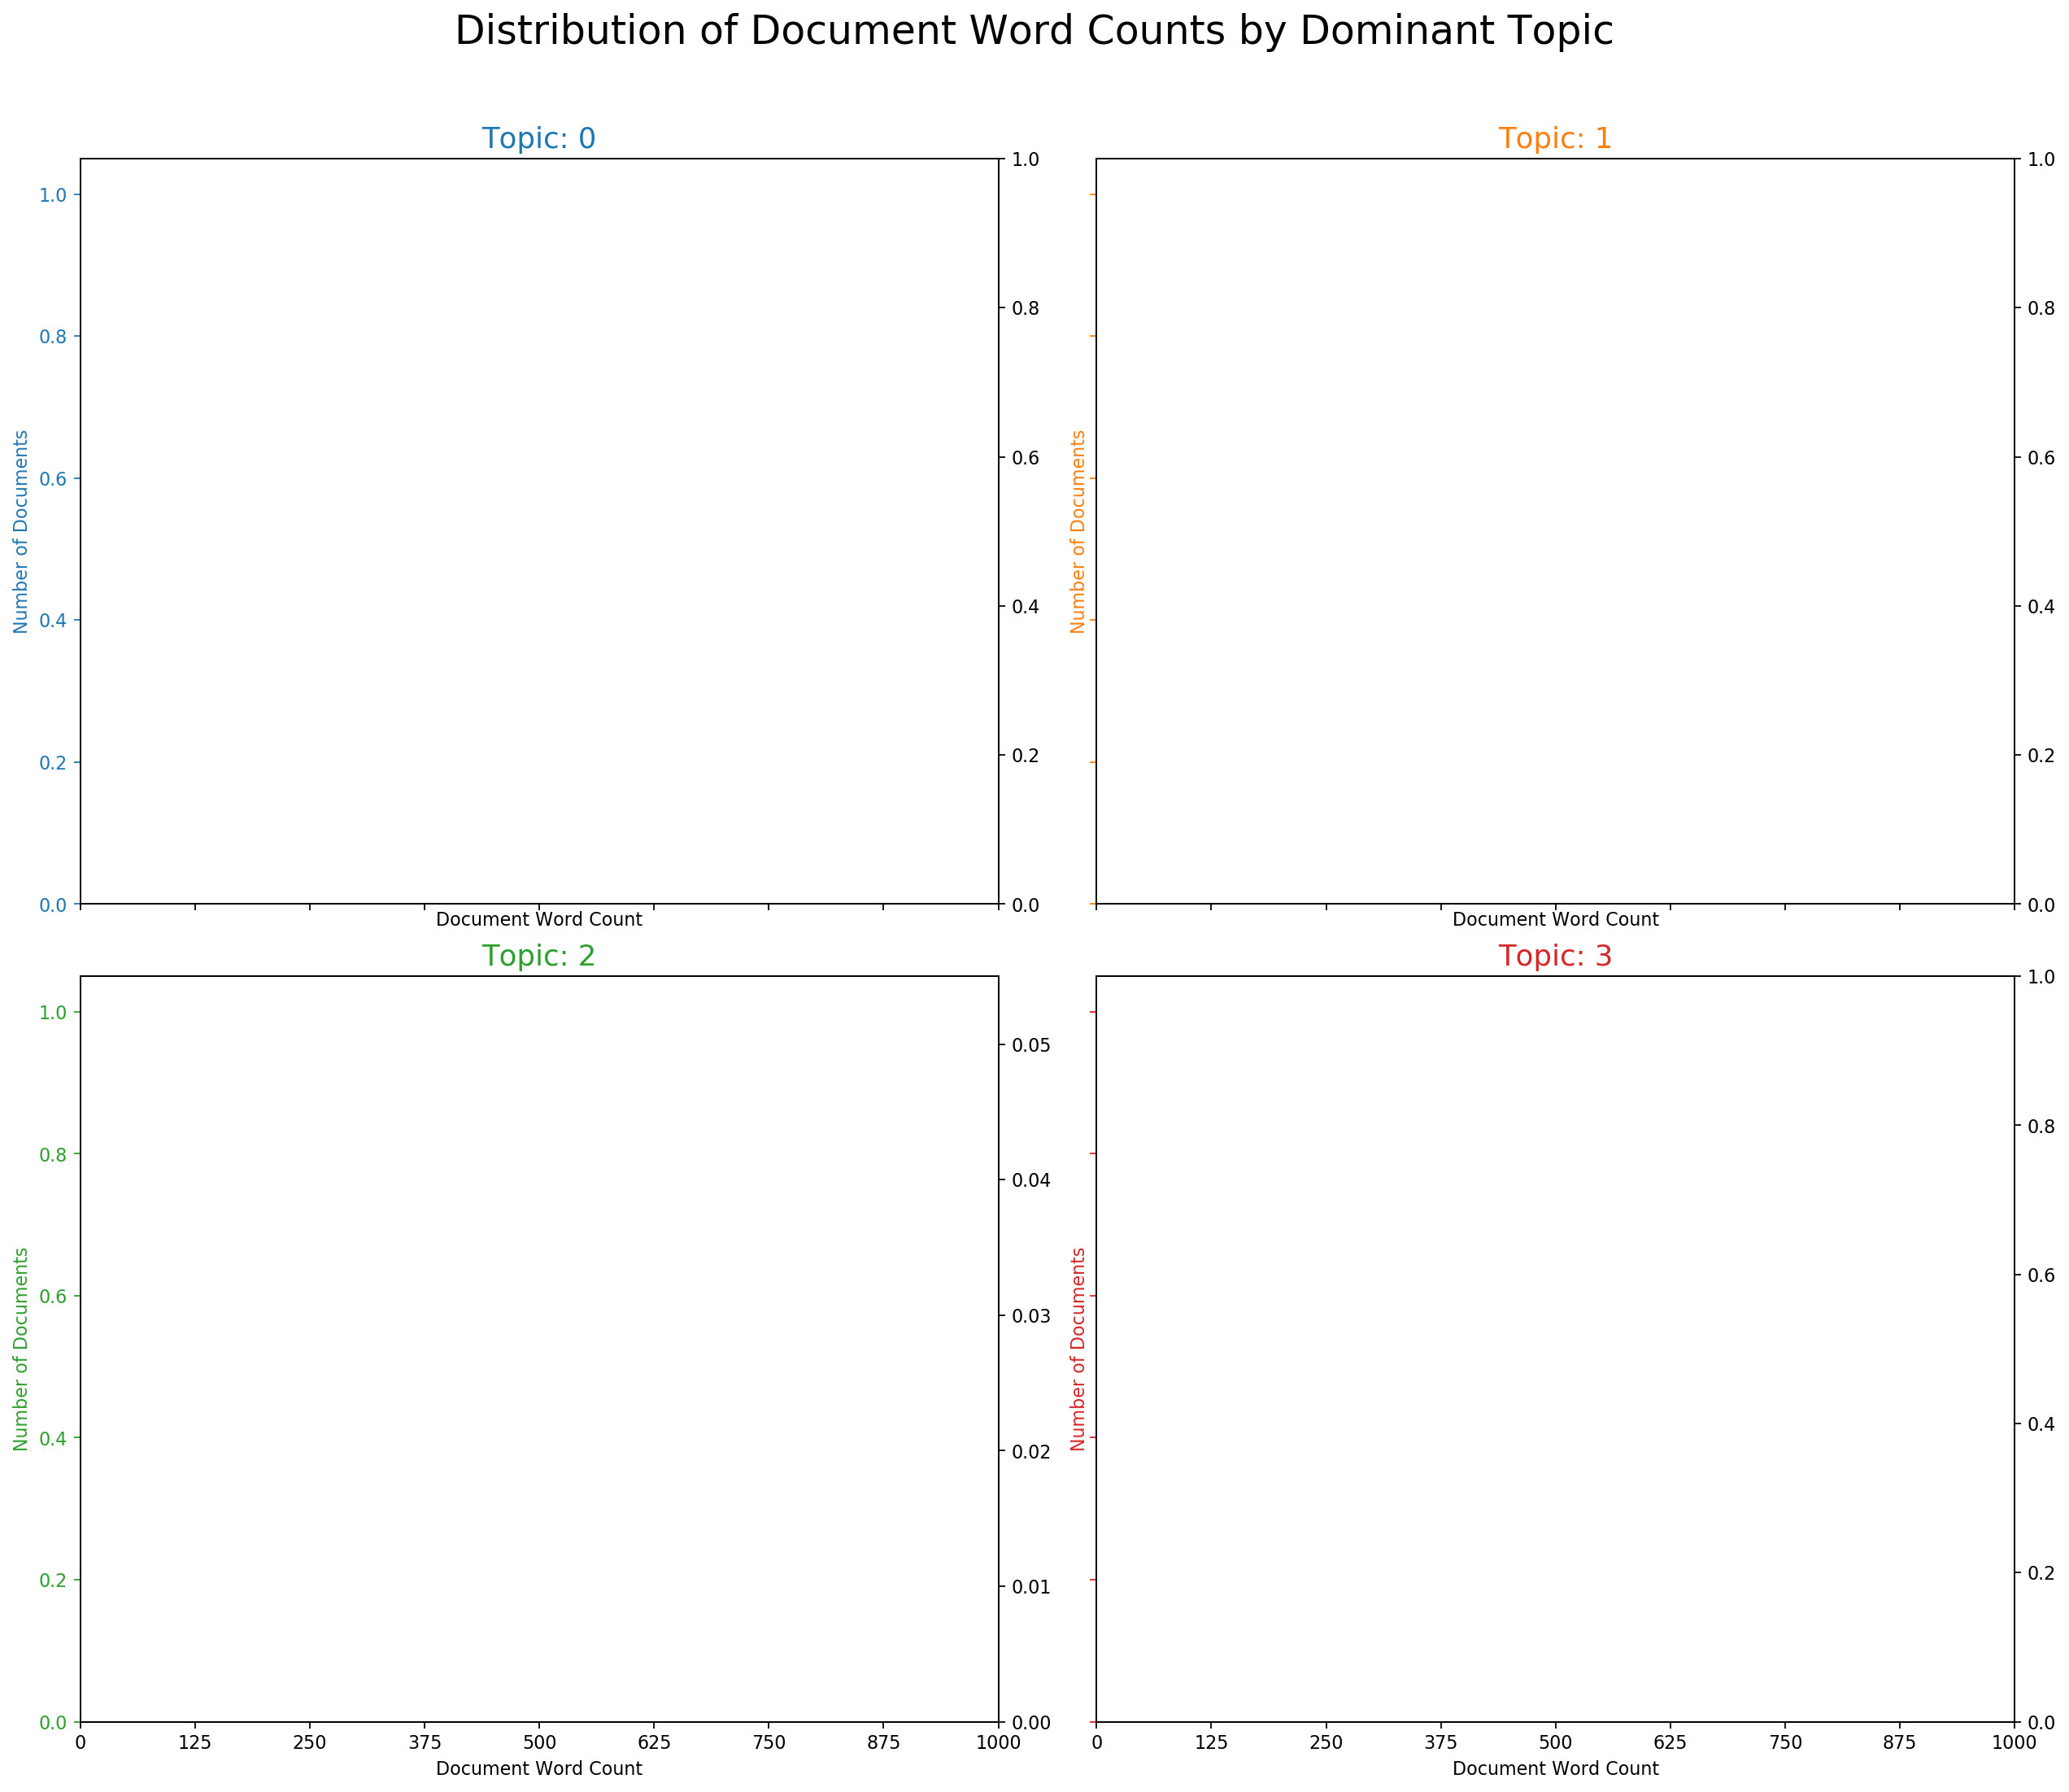

In [26]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

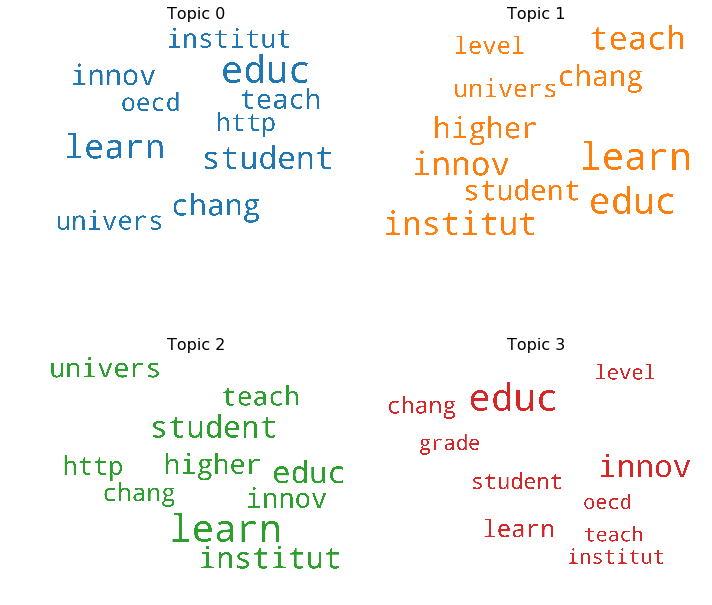

In [30]:
# 1. Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

stop_words = gensim.parsing.preprocessing.STOPWORDS

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

IndexError: list index out of range

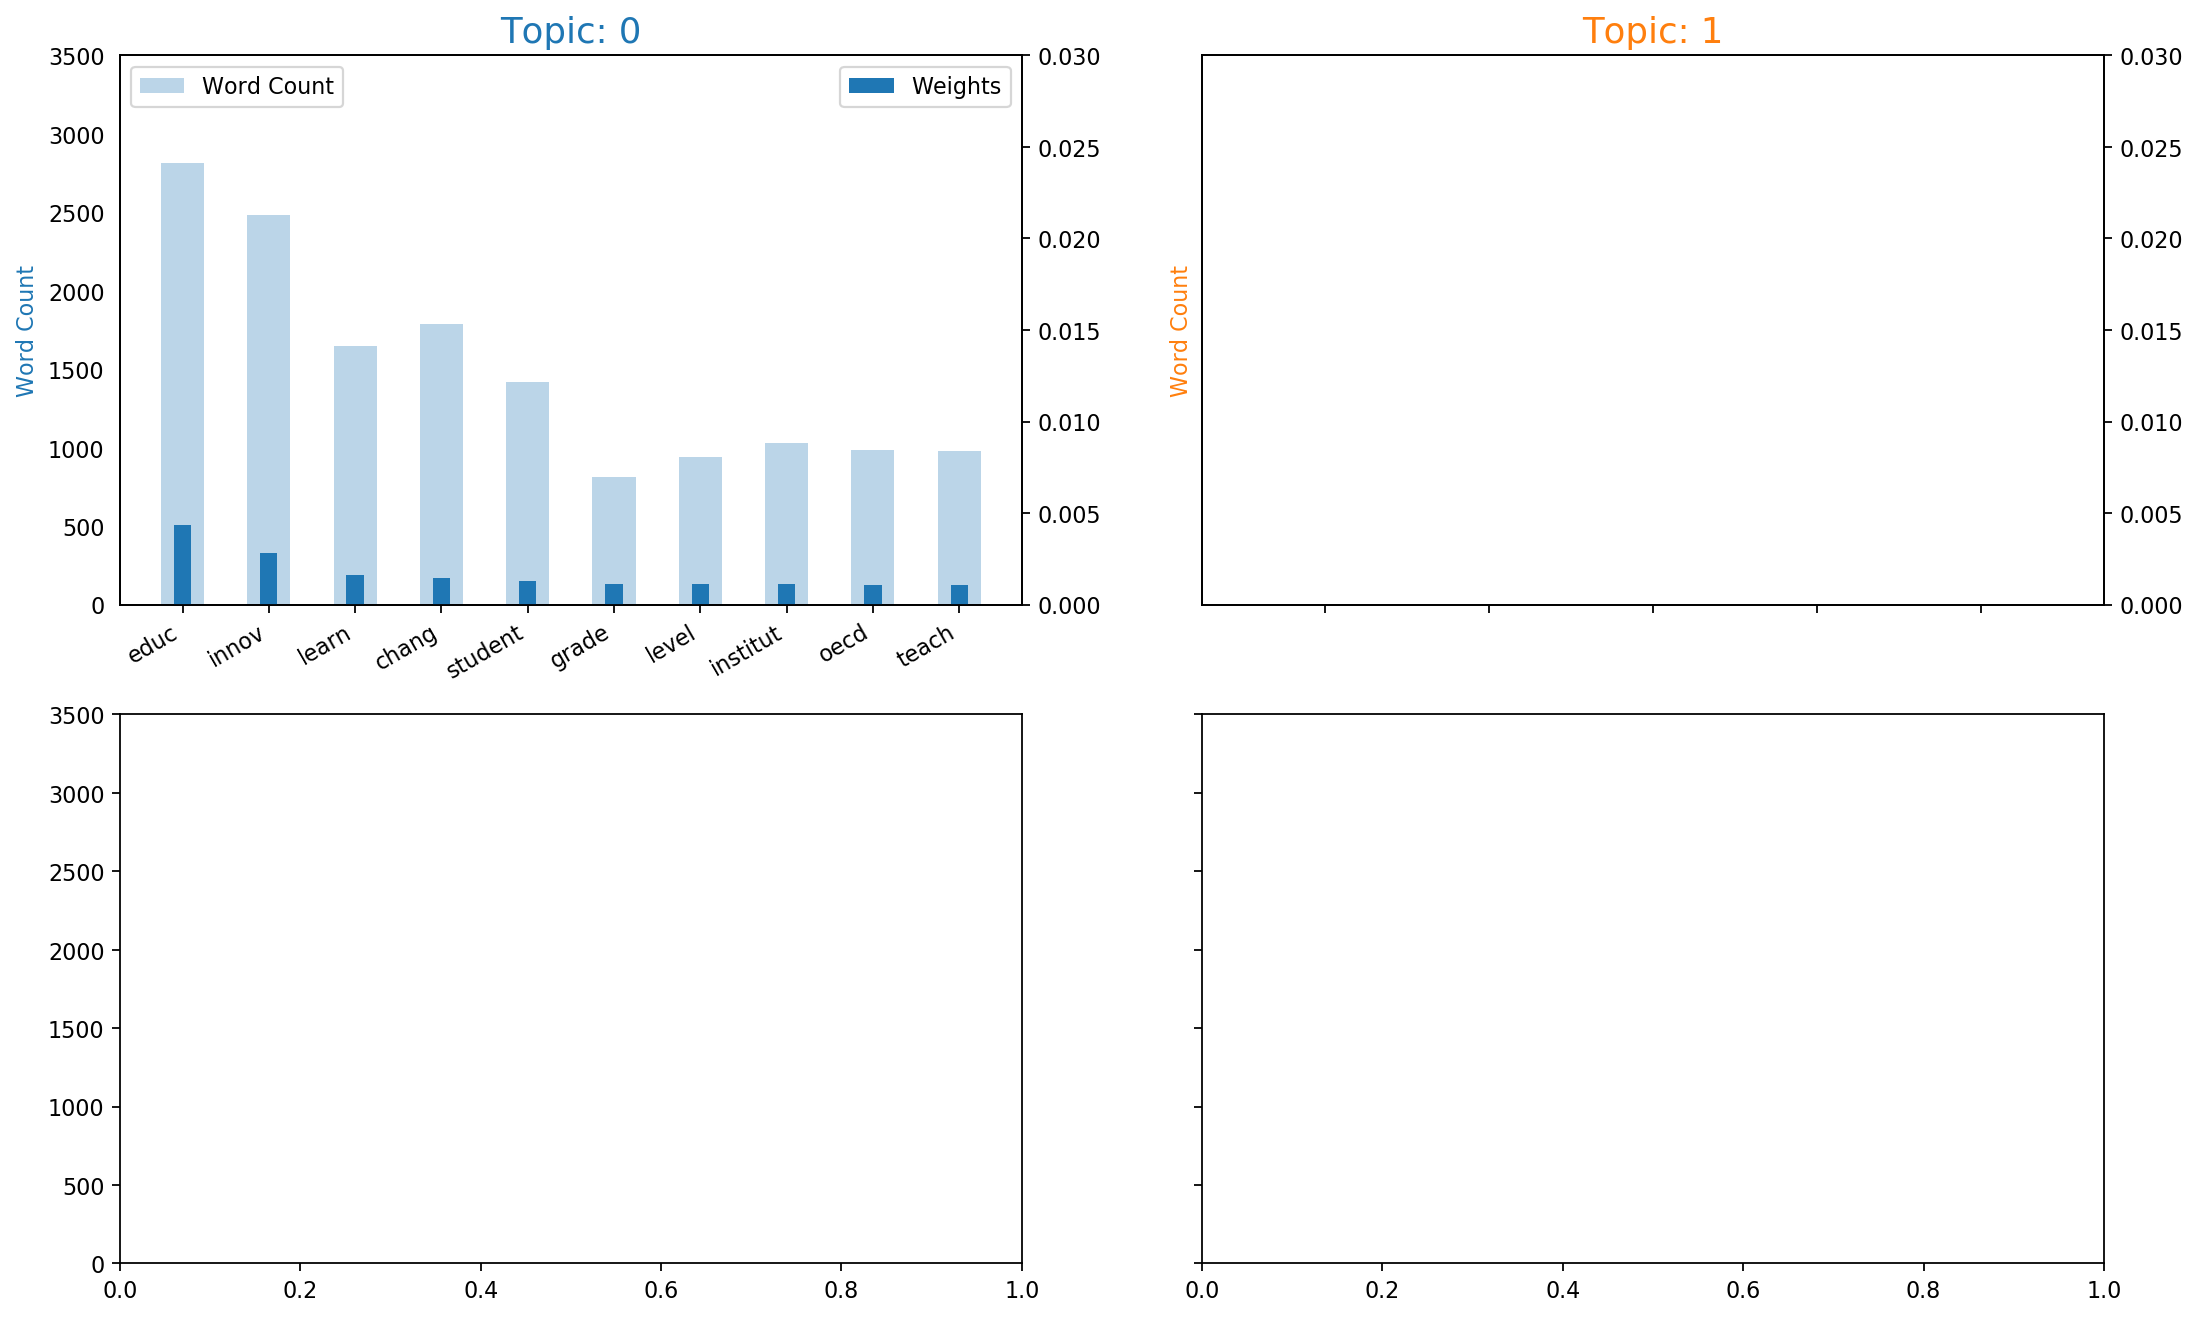

In [43]:
from collections import Counter


topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in documents for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

TypeError: 'SlicedCorpus' object does not support indexing

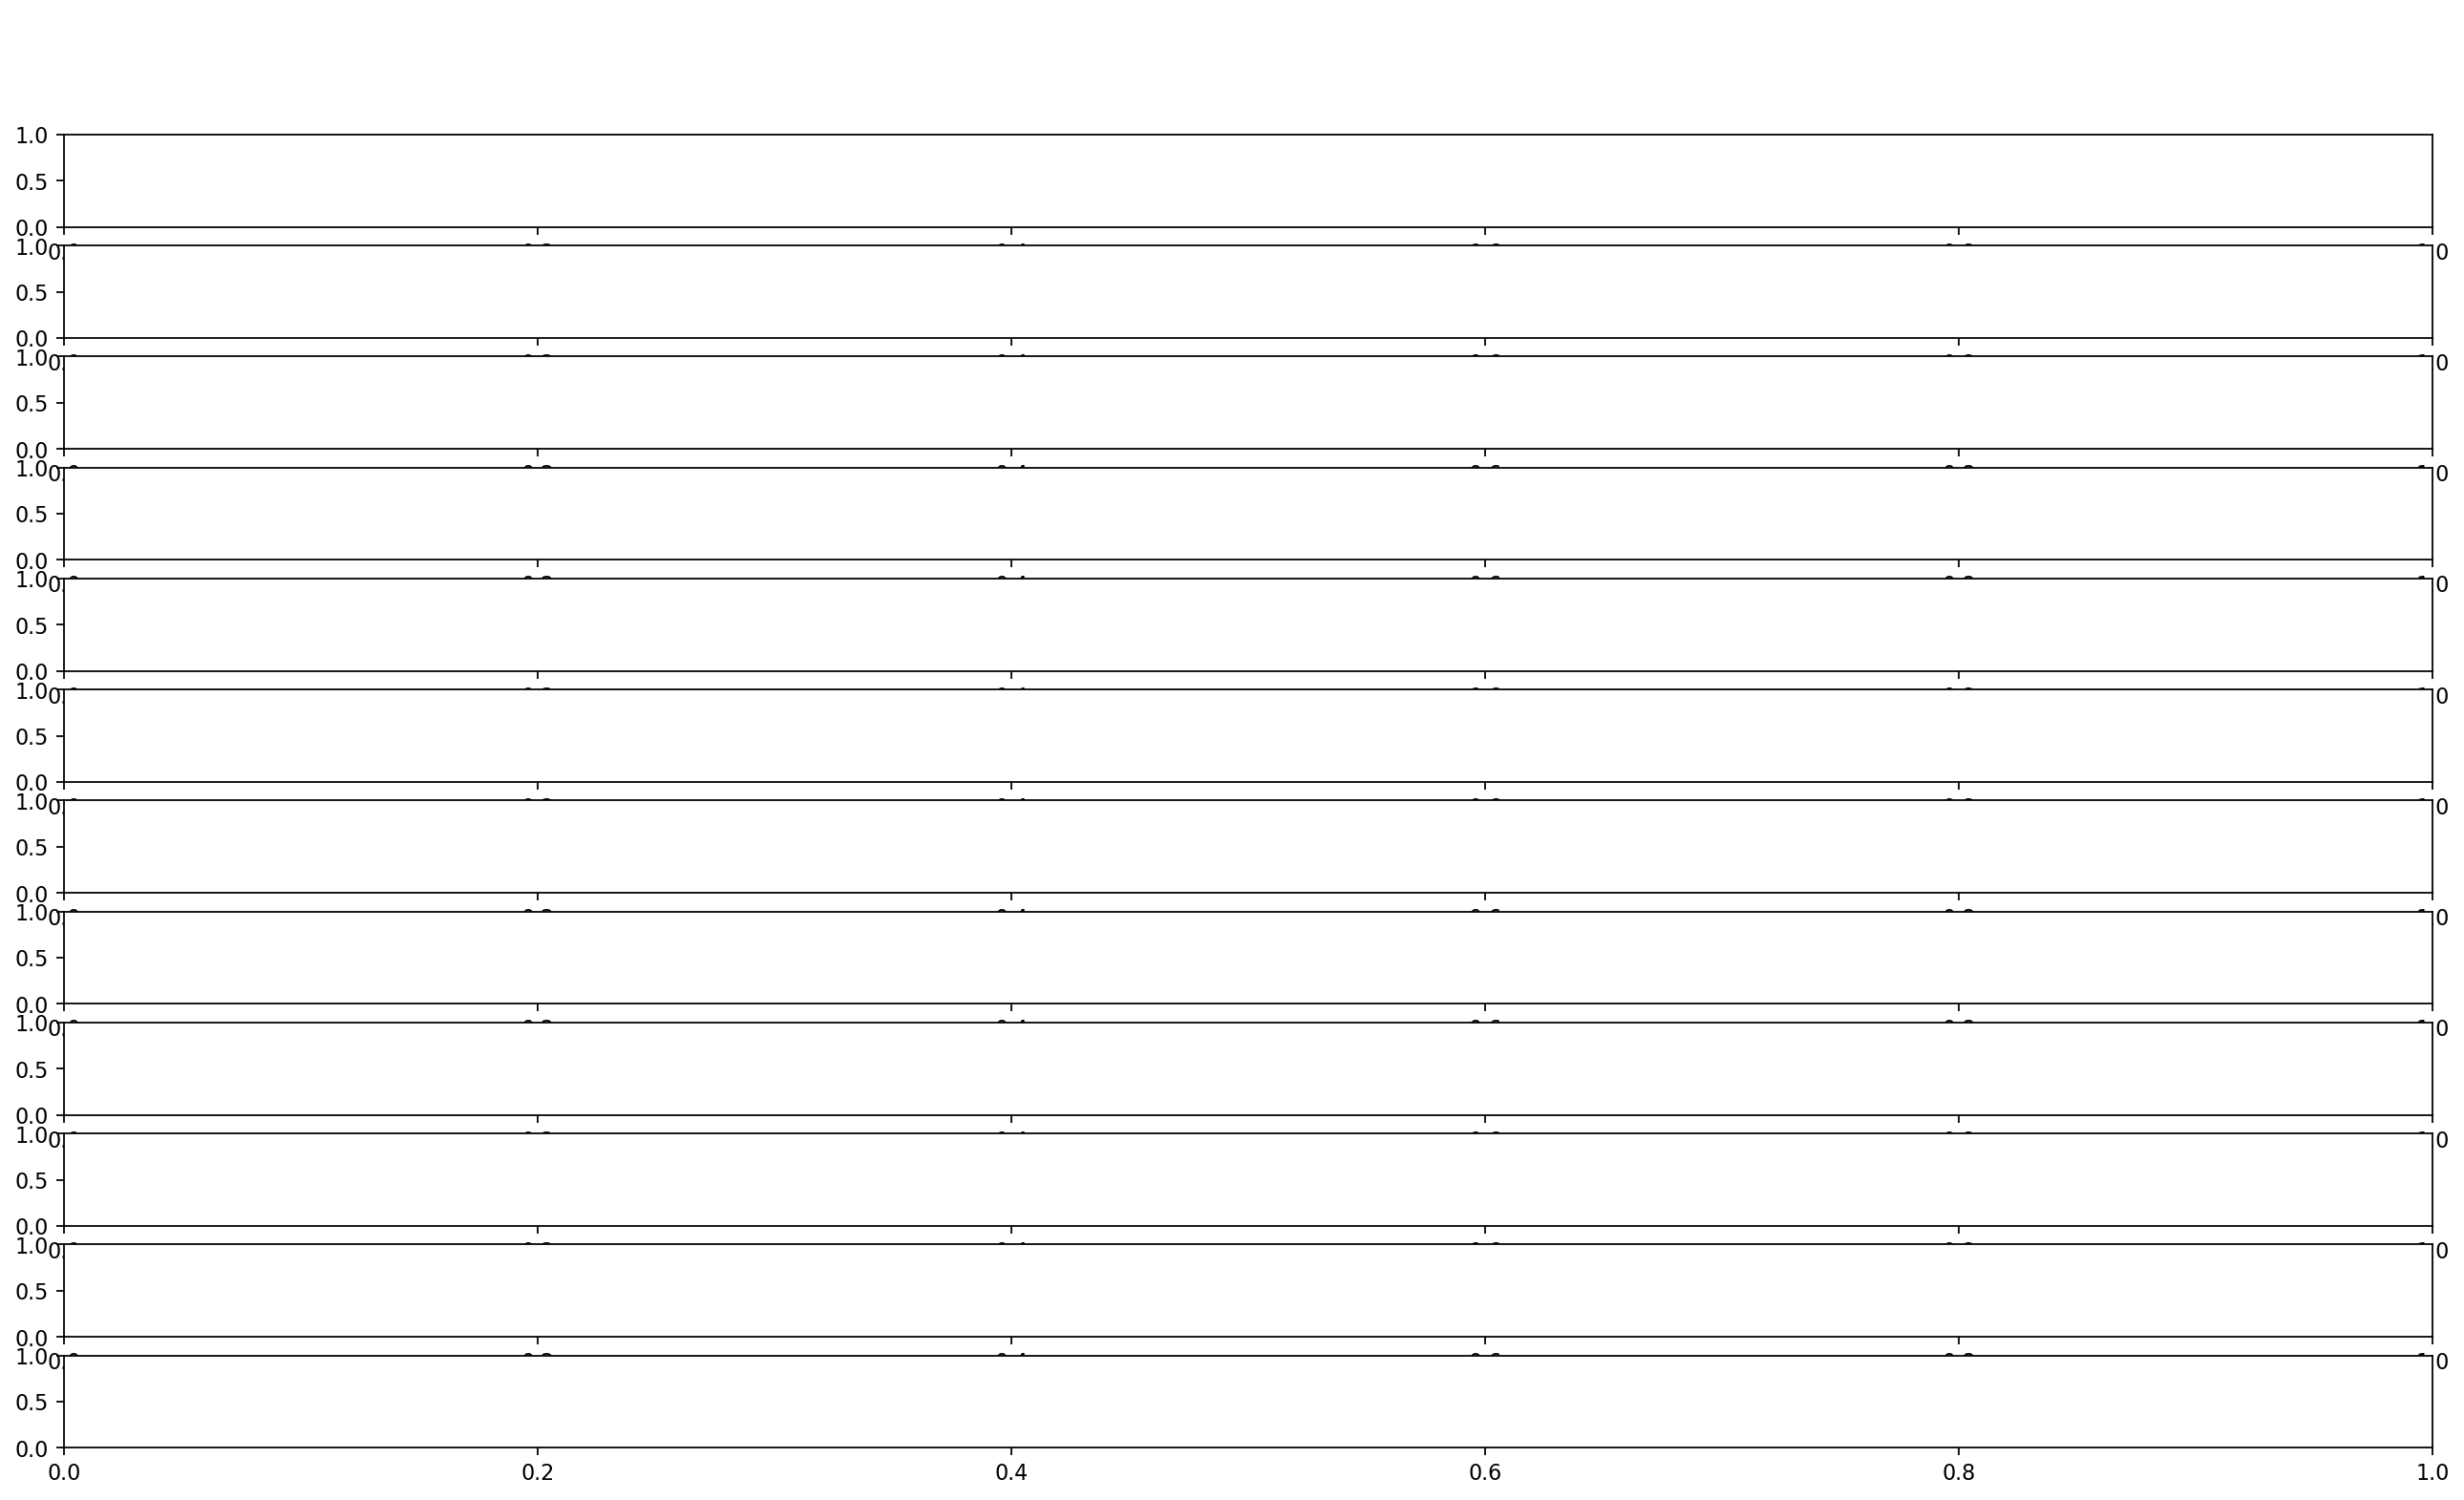

In [44]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [45]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

* The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
* The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [46]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x480 with 2 Axes>

## t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [49]:
# Get topic weights and dominant topics ------------

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.182869
[t-SNE] KL divergence after 450 iterations: 0.048725


Loading BokehJS ...

## pyLDAVis
Finally, `pyLDAVis` is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for `LdaModel()`.

In [50]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      45.762650        1       1 -0.319168 -0.199315
2      22.466574        1       2 -0.254158  0.072795
17     17.977682        1       3 -0.227946  0.091644
19      9.459453        1       4  0.214215 -0.169351
13      4.332723        1       5 -0.174399  0.057560
15      0.000074        1       6 -0.044906 -0.058277
12      0.000066        1       7 -0.007596 -0.051420
9       0.000064        1       8  0.017444  0.016366
10      0.000062        1       9  0.028425 -0.024820
1       0.000062        1      10  0.061709  0.031914
5       0.000062        1      11  0.051961  0.015776
8       0.000061        1      12  0.060225  0.016650
4       0.000061        1      13  0.078551  0.034109
3       0.000061        1      14  0.081491  0.028927
18      0.000056        1      15  0.087208  0.036683
7       0.000056        1      16  0.078245  0.029590
11      0.000056        1      17  0.083090  0.028943
16      0.000056        1      18  0.065304  0.014499
14      0.000056        1      19  0.069952  0.021115
0       0.000056        1      20  0.050354  0.006613, topic_info=     Category         Freq      Term        Total  loglift  logprob
4621  Default  2461.000000     innov  2461.000000  30.0000  30.0000
6     Default  2787.000000      educ  2787.000000  29.0000  29.0000
3433  Default  1770.000000     chang  1770.000000  28.0000  28.0000
2984  Default   984.000000      oecd   984.000000  27.0000  27.0000
267   Default   877.000000     figur   877.000000  26.0000  26.0000
4038  Default   809.000000     grade   809.000000  25.0000  25.0000
7600  Default  1397.000000   student  1397.000000  24.0000  24.0000
1080  Default  1642.000000     learn  1642.000000  23.0000  23.0000
6302  Default   936.000000     level   936.000000  22.0000  22.0000
5099  Default   785.000000     point   785.000000  21.0000  21.0000
287   Default   689.000000   countri   689.000000  20.0000  20.0000
6967  Default   964.000000     teach   964.000000  19.0000  19.0000
3341  Default  1019.000000  institut  1019.000000  18.0000  18.0000
5040  Default   572.000000    sector   572.000000  17.0000  17.0000
4541  Default   564.000000    averag   564.000000  16.0000  16.0000
2507  Default   599.000000   teacher   599.000000  15.0000  15.0000
5802  Default   540.000000    school   540.000000  14.0000  14.0000
6279  Default   551.000000  signific   551.000000  13.0000  13.0000
1470  Default   647.000000        us   647.000000  12.0000  12.0000
3570  Default   623.000000      data   623.000000  11.0000  11.0000
3882  Default   648.000000       new   648.000000  10.0000  10.0000
2649  Default   414.000000      size   414.000000   9.0000   9.0000
7133  Default   768.000000    higher   768.000000   8.0000   8.0000
3723  Default   448.000000    effect   448.000000   7.0000   7.0000
3716  Default   459.000000    scienc   459.000000   6.0000   6.0000
3721  Default   777.000000      http   777.000000   5.0000   5.0000
4408  Default   734.000000   univers   734.000000   4.0000   4.0000
1697  Default   428.000000    system   428.000000   3.0000   3.0000
5561  Default   414.000000   increas   414.000000   2.0000   2.0000
6046  Default   294.000000   absolut   294.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
4621  Topic20     0.000173     innov  2461.027832  -2.0729  -5.8630
1080  Topic20     0.000097     learn  1642.820068  -2.2453  -6.4395
3433  Topic20     0.000088     chang  1770.576538  -2.4220  -6.5414
4038  Topic20     0.000069     grade   809.875977  -1.8807  -6.7822
7600  Topic20     0.000078   student  1397.927612  -2.2982  -6.6539
6302  Topic20     0.000069     level   936.796753  -2.0290  -6.7850
5802  Topic20     0.000059    school   540.320862  -1.6396  -6.9458
3341  Topic20     0.000068  institut  1019.778259  -2.1223  -6.7934
2984  Topic20     0.000067      oecd   984.000671